# Анализ рынка видеоигр

## Описание проекта
Интернет-магазин, продающий по всему миру компьютерные игры, в декабре 2016 года планирует кампанию продвижения на 2017 год. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы. Нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

## Загрузка данных
Откроем файл с данными и изучим общую информацию.

In [1]:
import pandas as pd
import numpy as np
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st

pd.options.mode.chained_assignment = None # уберём предупреждения

In [2]:
df = pd.read_csv('games.csv')
df.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


## Предварительная обработка данных

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Для удобства покажем количество пропусков на диаграмме:

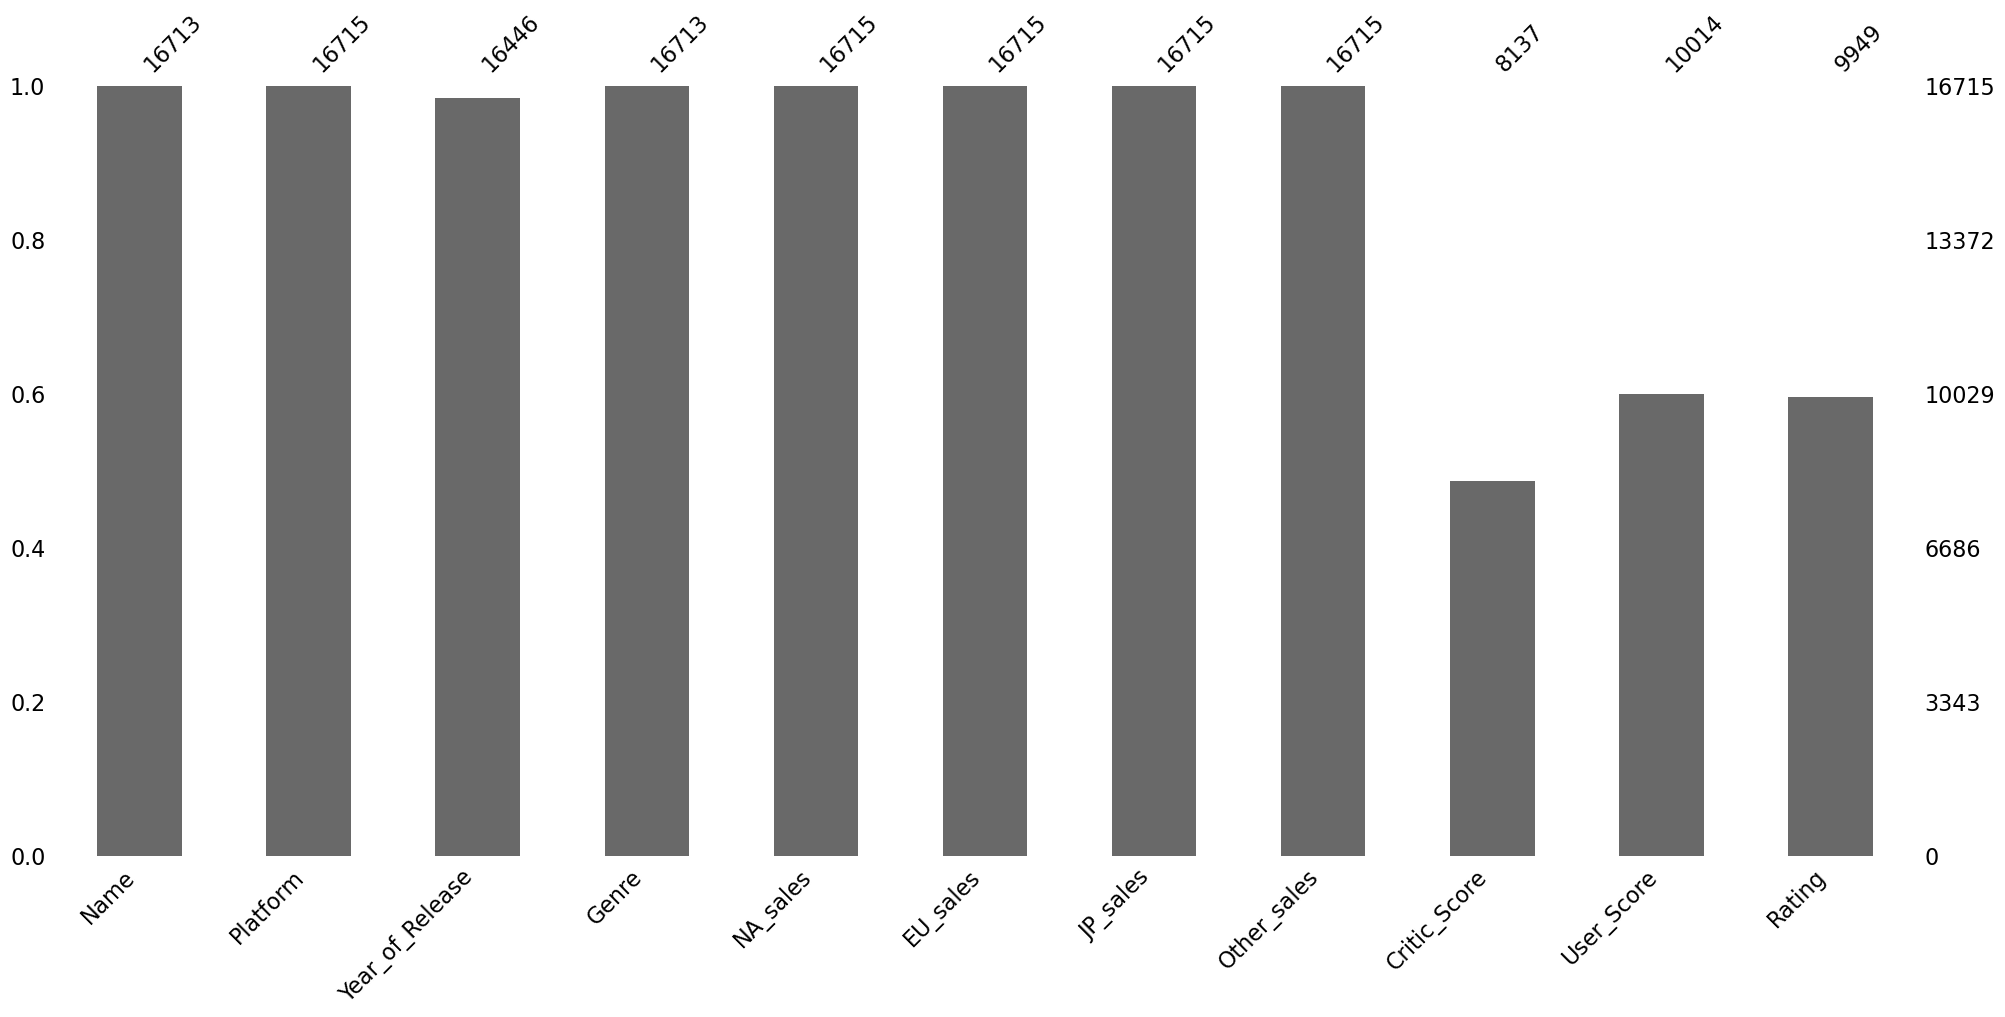

In [4]:
msno.bar(df);

Приведём названия столбцов к нижнему регистру.

In [5]:
df.columns = df.columns.str.lower()
df.head(3)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E


Посмотрим что можно сделать с **пропусками**. Они есть в столбцах `name`, `year_of_release`, `genre`, `critic_score`, `user_score` и `rating`.

In [6]:
df.loc[df['name'].isna()==True]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Строки с пропусками в `name` можно удалить - полезной информации они нам не дадут.

In [7]:
df = df.loc[df['name'].isna()==False]

Пропуски в `critic_score`, `user_score` и `rating`, скорее всего, означают, что для этих игр действительно нет данных об оценках и рейтингах. Оставим их как есть.

Немного смущает количество игр с неуказанным годом выхода. Посмотрим на них поближе:

In [8]:
df.loc[df['year_of_release'].isna()==True].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 269 entries, 183 to 16522
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             269 non-null    object 
 1   platform         269 non-null    object 
 2   year_of_release  0 non-null      float64
 3   genre            269 non-null    object 
 4   na_sales         269 non-null    float64
 5   eu_sales         269 non-null    float64
 6   jp_sales         269 non-null    float64
 7   other_sales      269 non-null    float64
 8   critic_score     154 non-null    float64
 9   user_score       175 non-null    object 
 10  rating           181 non-null    object 
dtypes: float64(6), object(5)
memory usage: 25.2+ KB


269 игр, для большинства из них известны оценки и рейтинги. Чтобы не потерять ценные данные, оставим пропуски без изменений.

Преобразуем данные в нужные типы. Год выхода игры - всегда целое число и можно было бы преобразовать его в `int`, однако мы решили оставить пропуски без изменений, а `NaN` в `int` преобразовать нельзя, поэтому оставим без изменений. Оценку пользователей логично было бы перевести в тип `float`, а рейтинги сделать категориальными значениями.

In [9]:
df['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

Тип `object` появляется в столбце с оценками пользователей из-за значения *tbd*, которое означает *to be decided* или *подлежит уточнению, в процессе выяснения*. Сейчас оценки нет, но позже появится. Для целей нашего анализа можно заменить *tbd* на *NaN*.

In [10]:
df['user_score'] = df['user_score'].replace({'tbd':np.nan}).astype('float')
df['rating'] = df['rating'].astype('category')
df.dtypes

name                 object
platform             object
year_of_release     float64
genre                object
na_sales            float64
eu_sales            float64
jp_sales            float64
other_sales         float64
critic_score        float64
user_score          float64
rating             category
dtype: object

Проверим есть ли в данных дубликаты по названию, платформе и году выхода.

In [11]:
df[df[['name','platform','year_of_release']].duplicated()==True]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
16230,Madden NFL 13,PS3,2012.0,Sports,0.0,0.01,0.0,0.0,83.0,5.5,E


Посмотрим чем различаются строки с этой игрой в других столбцах.

In [12]:
df[(df['name']=='Madden NFL 13')&(df['platform']=='PS3')]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
604,Madden NFL 13,PS3,2012.0,Sports,2.11,0.22,0.0,0.23,83.0,5.5,E
16230,Madden NFL 13,PS3,2012.0,Sports,0.00,0.01,0.0,0.00,83.0,5.5,E


Во второй строке явно неполные данные об игре. Удалим её.

In [13]:
df = df.drop_duplicates(subset=['name','platform','year_of_release'], keep='first')
df[(df['name']=='Madden NFL 13')&(df['platform']=='PS3')]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
604,Madden NFL 13,PS3,2012.0,Sports,2.11,0.22,0.0,0.23,83.0,5.5,E


Посчитаем суммарные продажи во всех регионах и запишем их в отдельный столбец.

In [14]:
df['total_sales'] = df['na_sales'] + df['eu_sales'] + df['jp_sales'] + df['other_sales']
df.insert(8, 'total_sales', df.pop('total_sales')) # Переместим столбец total_sales после всех столбцов с продажами
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,total_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,82.54,76.0,8.0,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,35.52,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,32.77,80.0,8.0,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,31.38,NaN,NaN,NaN


**Вывод:**

Данные очищены от дубликатов и некоторых пропусков. Пропуски в `critic_score`, `user_score` и `rating`, скорее всего, означают, что для этих игр действительно нет данных об оценках и рейтингах, было решено оставить их без изменения. 

Для анализа рынка видеоигр и предпочтений покупателей данных достаточно.

## Исследовательский анализ данных

### Сколько игр выпускалось в разные годы

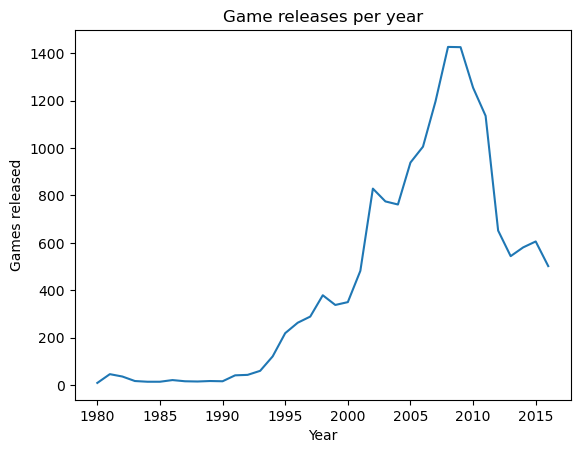

In [15]:
(
    df.groupby('year_of_release')['name']
    .count()
    .plot(kind='line', ylabel='Games released', xlabel='Year', 
          title='Game releases per year')
);

Больше всего игр в год выходило с 2005 по 2011 годы, потом количество игр в год пошло на спад.

### Как менялись продажи по платформам по годам

Выберем платформы с наибольшими суммарными продажами и посмотрим как распределялись для них продажи по годам.

In [16]:
top_platforms = (df.groupby('platform')['total_sales']
                 .sum()
                 .sort_values(ascending=False)
                 .head(10)
                 .reset_index()['platform']
                 .to_list())
top_platforms

['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS', 'GBA', 'PS4', 'PSP', 'PC']

In [17]:
# Посчитаем продажи топовых платформ по годам
ts_platforms = (df.query('platform in @top_platforms')
                .pivot_table(values='total_sales', index='year_of_release', columns='platform', aggfunc='sum'))
ts_platforms.head()

platform,DS,GBA,PC,PS,PS2,PS3,PS4,PSP,Wii,X360
year_of_release,,,,,,,,,,
1985.0,0.02,NaN,0.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1988.0,NaN,NaN,0.03,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1992.0,NaN,NaN,3.03,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1994.0,NaN,NaN,12.87,6.03,NaN,NaN,NaN,NaN,NaN,NaN
1995.0,NaN,NaN,4.22,35.96,NaN,NaN,NaN,NaN,NaN,NaN


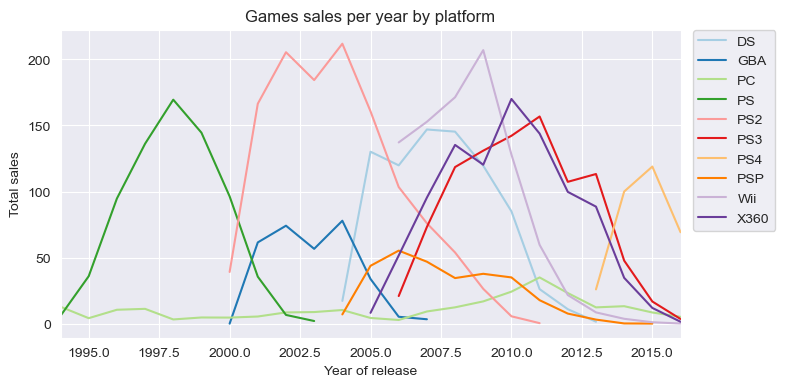

In [18]:
# Зададим цветовую схему графика
sns.set_palette('Paired')
sns.set_style('darkgrid')

# Покажем как менялись продажи на графике
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(ts_platforms)
ax.legend(ts_platforms.columns, bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
ax.set_xlim([1994, 2016]) # зададим лимит в 2 млн. копий
plt.xlabel('Year of release')
plt.ylabel('Total sales')
plt.title('Games sales per year by platform');

Можно заметить, что каждая платформа "живёт" примерно 7-8 лет. В 2015 году новое поколение консолей набирает обороты.

### Актуальное состояние рынка
С 2012 года на рынок начало выходить новое поколение консолей. Актуальным периодом для анализа состояния рынка в 2016 году будем считать 2013-2015 годы.  Посмотрим какие консоли были в лидерах продаж с 2013 по 2015 годы, какие росли в продажах, а какие падали.

In [19]:
# Оставим в датасете только актуальные данные
df_a = df.query('year_of_release >= 2013')
df_a['year_of_release'] = df_a['year_of_release'].astype('int')
df_a['year_of_release'].min()

2013

Посмотрим игры на каких платформах больше всего продавались в этом периоде:

In [20]:
df_a.groupby('platform')['total_sales'].sum().sort_values(ascending=False)

platform
PS4     314.14
PS3     181.43
XOne    159.32
3DS     143.25
X360    136.80
WiiU     64.63
PC       39.43
PSV      32.99
Wii      13.66
PSP       3.50
DS        1.54
Name: total_sales, dtype: float64

У каждого из ключевых производителей консолей на рынке присутствует несколько моделей. Новые модели *PlayStation*, *Microsoft* и *Nintendo* обогнали по продажам старые.

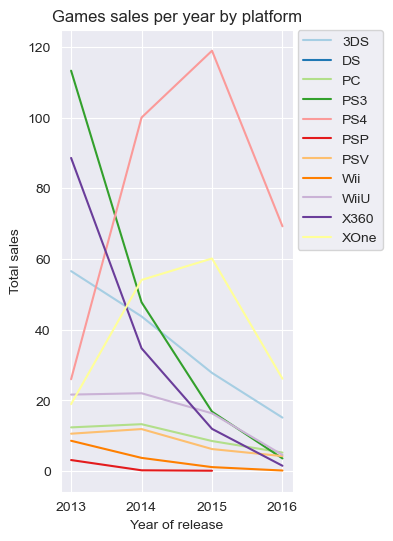

In [21]:
# Покажем динамику продаж на графике
fig, ax = plt.subplots(figsize=(3, 6))
ax.plot(df_a.pivot_table(values='total_sales', index='year_of_release', columns='platform', aggfunc='sum'))
ax.legend(df_a.pivot_table(values='total_sales', index='year_of_release', columns='platform', aggfunc='sum').columns,
         bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.xlabel('Year of release')
plt.ylabel('Total sales')
plt.title('Games sales per year by platform');

Заметно падают в продажах PS3  и X360, их место в топе занимают PS4 и XOne. Также уходят со сцены 3DS, Wii и PSP. WiiU, скорее всего, исчерпала свой потенциал роста и тоже будет снижаться.

Можно предположить, что в 2017 году лидерами продаж будут **PS4** и **XOne**, на них и следует делать главную ставку в продвижении.

Чтобы посмотреть, как распределяются продажи игр по платформам, построим графики типа "ящик с усами":

In [22]:
# Зададим цвета для платформ, чтобы они одинаково отображались на всех графиках
self_palette ={'PS4':'#3dc1d3',
                'PS3':'#f5cd79',
               'X360':'#546de5',
               'XOne':'#e15f41',
               '3DS':'#c44569',
              'PC':'#574b90',
              'WiiU':'#f78fb3',
              'Wii':'#f19066',
              'PSV':'#e66767',
              'DS':'#303952',
              'PSP':'#f3a683'}

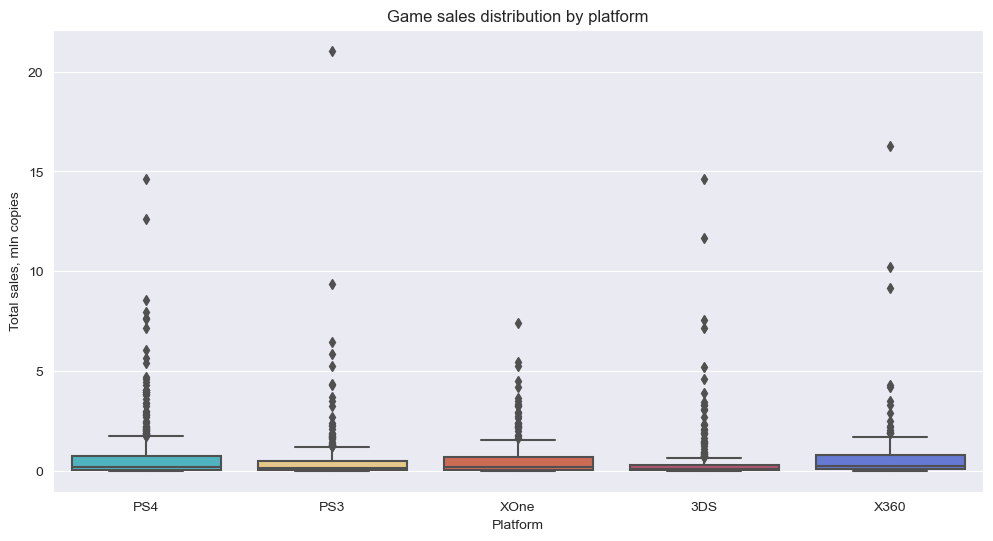

In [23]:
fig, ax = plt.subplots(figsize=(12, 6))
ax = sns.boxplot(x=df_a['platform'], y=df_a['total_sales'], palette=self_palette,
                order=df_a.groupby('platform')['total_sales'].sum().sort_values(ascending=False).head().index)
plt.xlabel('Platform')
plt.ylabel('Total sales, mln copies')
plt.title('Game sales distribution by platform');

Видим, что в данных много выбросов. Почти на каждой платформе были "выстрелившие" игры, которые продались миллионами копий. Попробуем их отбросить и посмотреть на средние значения продаж по платформам.

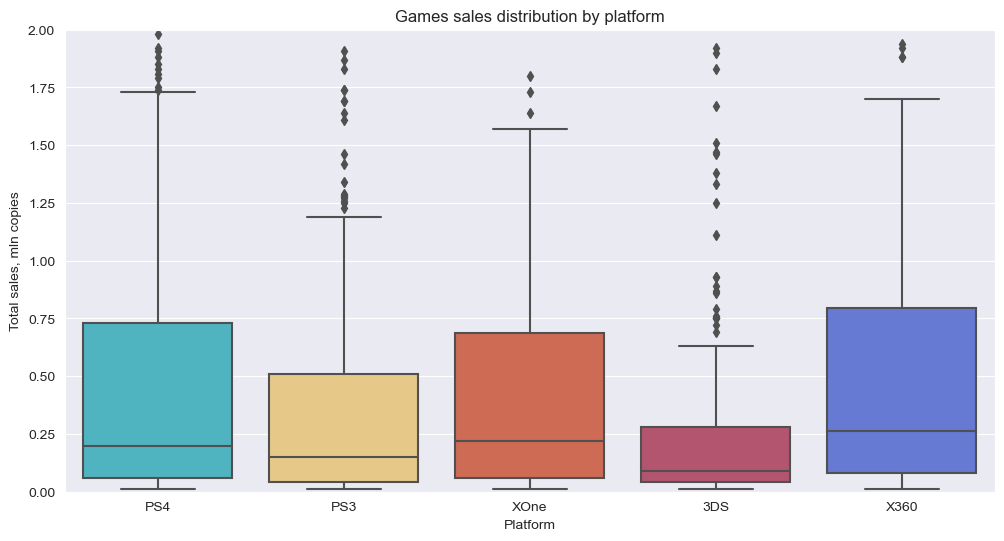

In [24]:
fig, ax = plt.subplots(figsize=(12, 6))
ax = sns.boxplot(x=df_a['platform'], y=df_a['total_sales'], palette=self_palette,
                order=df_a.groupby('platform')['total_sales'].sum().sort_values(ascending=False).head().index)
ax.set_ylim([0, 2]) # зададим лимит в 2 млн. копий
plt.xlabel('Platform')
plt.ylabel('Total sales, mln copies')
plt.title('Games sales distribution by platform');

В среднем больше популярных игр вышло на платформе X360: здесь и медиана выше остальных платформ, и граница четвёртого квартиля приближается к двум миллионам копий. Ко "второму эшелону" по средним продажам игр можно отнести PS3, PS4, XOne, Wii и WiiU.

### Влияние отзывов на продажи
Чтобы проверить влияют ли отзывы критиков и пользователей на продажи игр, возьмём платформу X360 и построим диаграммы рассеяния, где по одной оси отложим продажи, а по другой оценки.

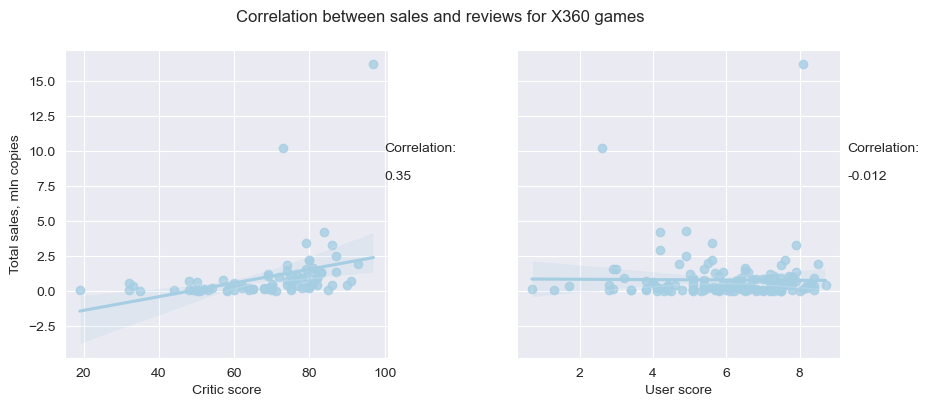

In [25]:
filtered = df_a.query('platform == "X360"')

fig, axes = plt.subplots(ncols=2, sharey=True, figsize=(10, 4))
sns.regplot(x='critic_score', y='total_sales', data=filtered, ax=axes[0])
sns.regplot(x='user_score', y='total_sales', data=filtered, ax=axes[1])
axes[0].set_xlabel('Critic score')
axes[1].set_xlabel('User score')
axes[0].set_ylabel('Total sales, mln copies')
axes[1].set_ylabel('')
axes[0].text(100, 10, 'Correlation:')
axes[0].text(100, 8, round(filtered['total_sales'].corr(filtered['critic_score']),3))
axes[1].text(9.3, 10, 'Correlation:')
axes[1].text(9.3, 8, round(filtered['total_sales'].corr(filtered['user_score']),3))
plt.subplots_adjust(wspace=0.4)
fig.suptitle('Correlation between sales and reviews for X360 games');

Можно предположить, что оценки критиков оказывают некоторое влияние на продажи игр для X360. Оценки пользователей с продажами не коррелируют.

Проверим будет ли это справедливо и для остальных платформ.

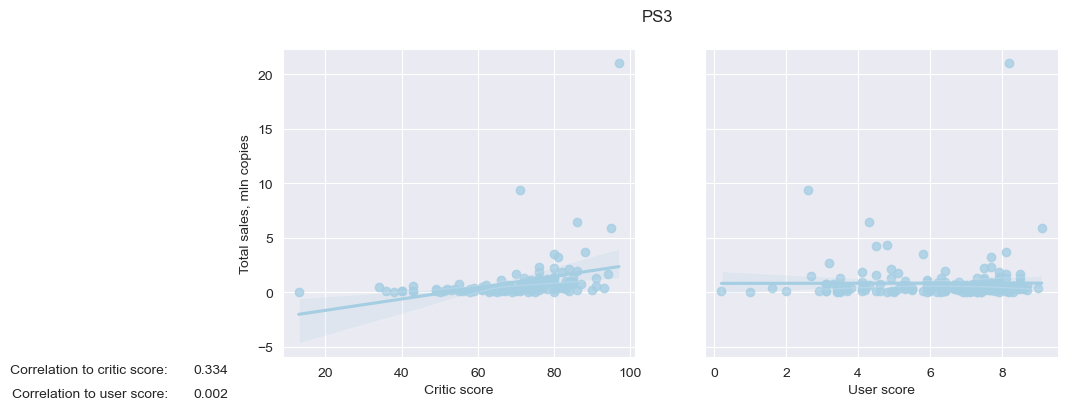

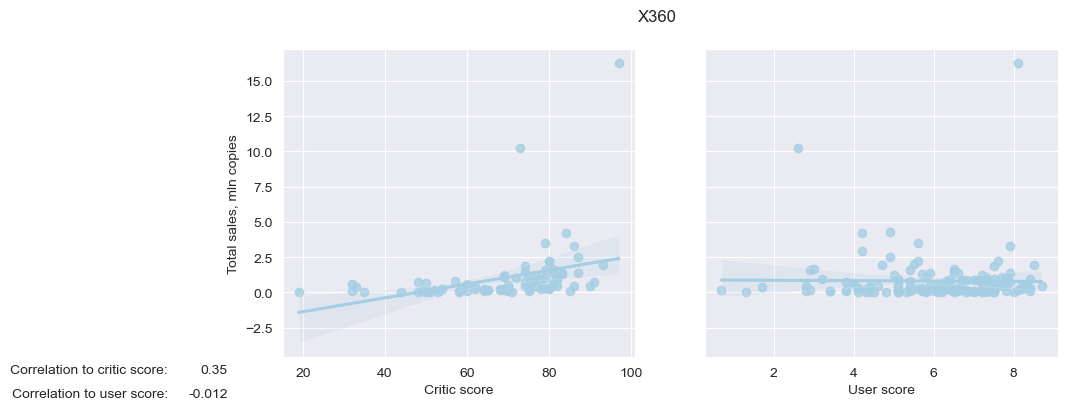

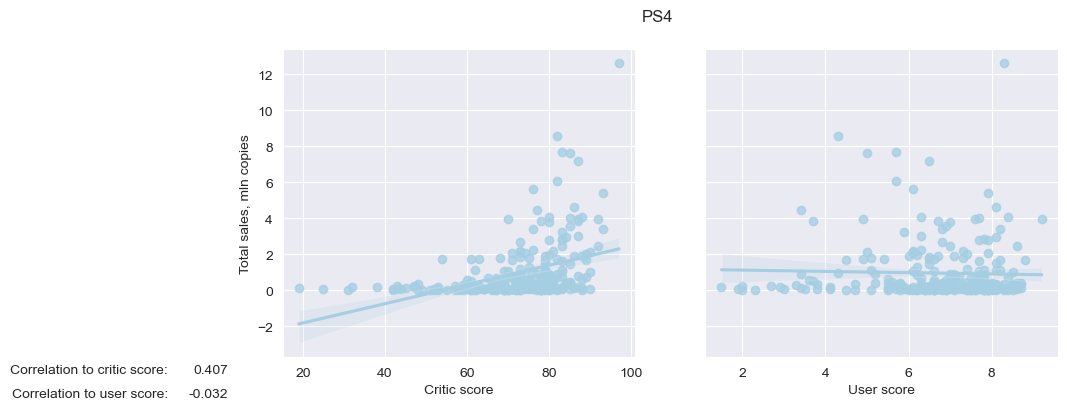

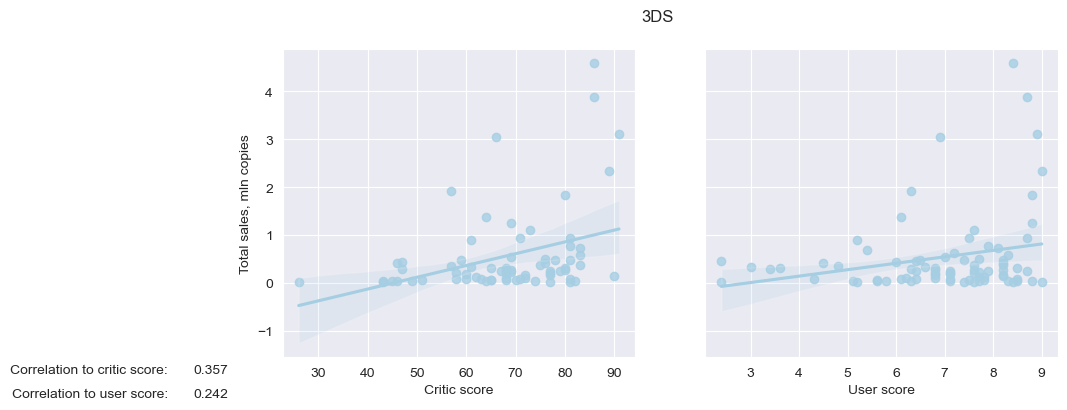

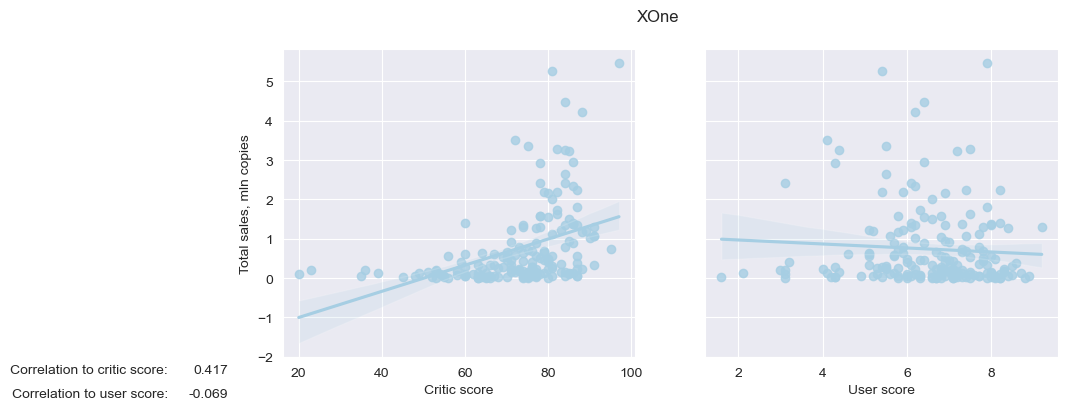

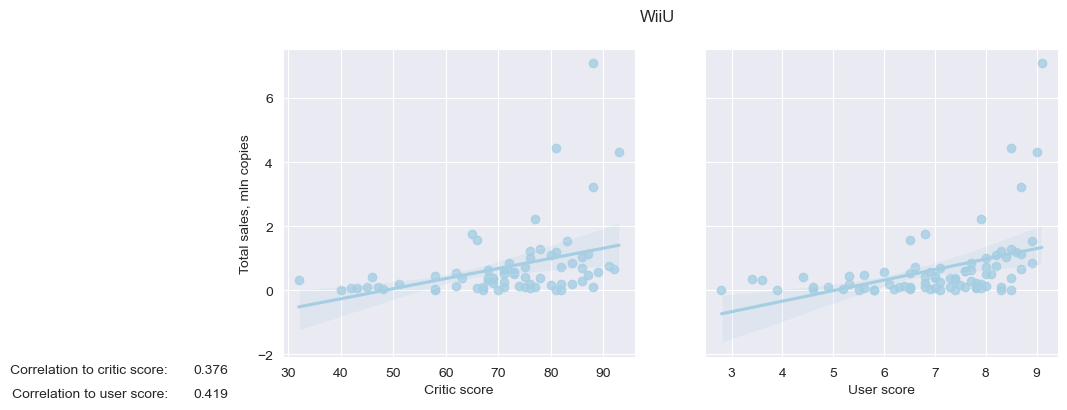

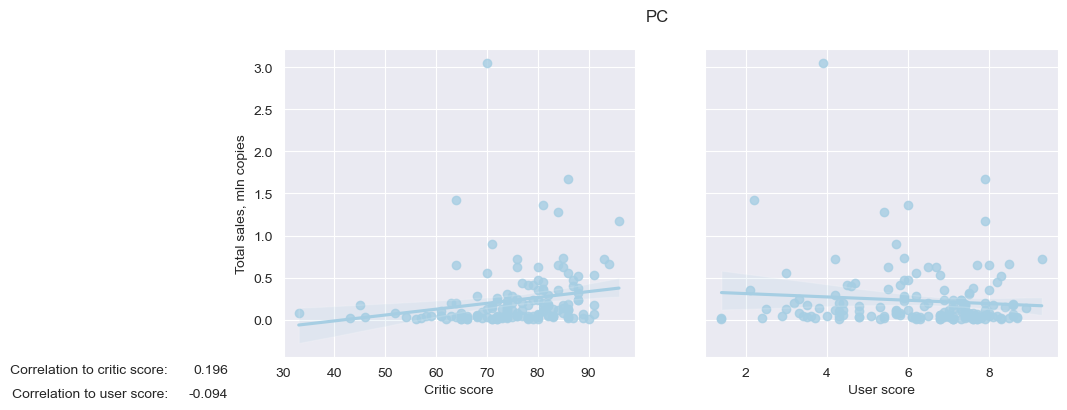

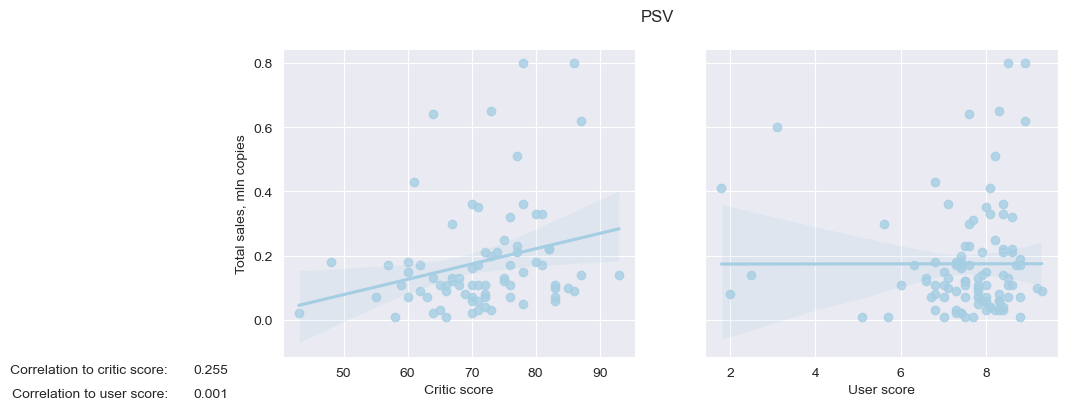

In [26]:
# Создадим список актуальных платформ
platforms = df_a['platform'].unique().tolist()

# Нарисуем графики для каждой из них
for p in platforms:
    # Отфильтруем данные для платформы
    filtered = df_a.query('platform == @p')
    
    # В датасете есть платформы с маленьким количеством оценок. 
    # Выполним проверку и не будем рисовать графики там, где оценок меньше 30.
    if filtered['critic_score'].count() >= 30 and filtered['user_score'].count() >= 30:
        fig, axes = plt.subplots(ncols=2, sharey=True, figsize=(10, 4))
        sns.regplot(x='critic_score', y='total_sales', data=filtered, ax=axes[0]) # график разброса для продаж и оценок критиков
        sns.regplot(x='user_score', y='total_sales', data=filtered, ax=axes[1]) # график разброса для продаж 
                                                                                # и оценок пользователей
        axes[0].set_xlabel('Critic score')
        axes[1].set_xlabel('User score')
        axes[0].set_ylabel('Total sales, mln copies')
        axes[1].set_ylabel('')
        fig.suptitle(p) # название платформы в заголовок графика
        
        # Посчитаем коэффициенты корреляции продаж и оценок
        plt.figtext(0.01, 0.07, 'Correlation to critic score:', horizontalalignment='right')
        plt.figtext(0.07, 0.07, round(filtered['total_sales'].corr(filtered['critic_score']),3), horizontalalignment='right')
        plt.figtext(0.01, 0.01, 'Correlation to user score:', horizontalalignment='right')
        plt.figtext(0.07, 0.01, round(filtered['total_sales'].corr(filtered['user_score']),3), horizontalalignment='right')
    else:
        pass;

Для всех платформ, оценки критиков положительно коррелируют с продажами. Оценки пользователей положительно коррелируют с продажами только для платформ Nintendo (3DS, WiiU).

### Зависимость продаж от жанра
Посмотрим как распределяются игры по жанрам.

In [27]:
# Зададим цвета для жанров, чтобы они одинаково отображались на всех графиках
genre_palette ={'Action':'#ea2027','Role-Playing':'#006266','Adventure':'#1b1464','Sports':'#5758bb','Shooter':'#6f1e51',
                'Misc':'#c4e538','Racing':'#ee5A24','Fighting':'#009432','Platform':'#0652dd','Simulation':'#9980fa',
                'Strategy':'#b53471','Puzzle':'#1289a7'}

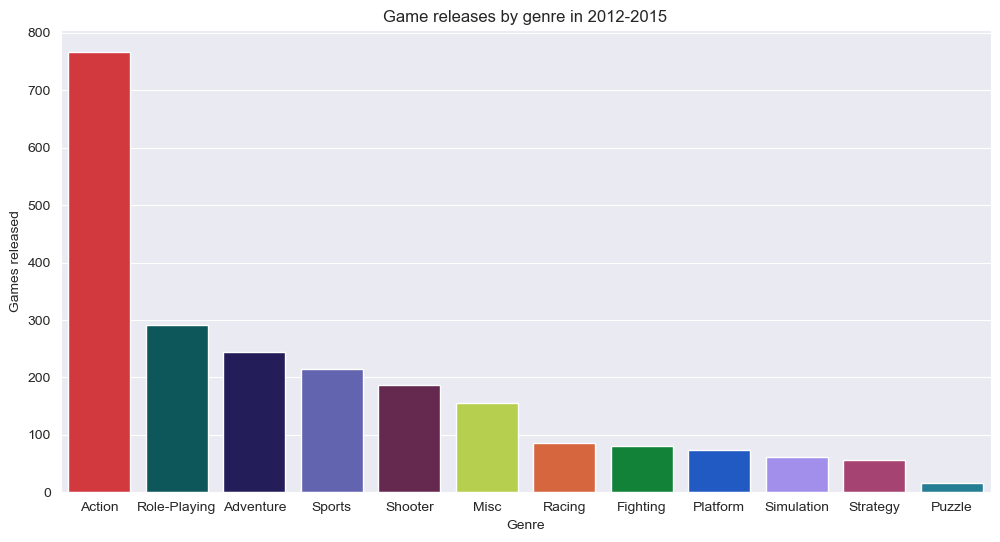

In [28]:
fig, ax = plt.subplots(figsize=(12, 6))
ax = sns.countplot(x=df_a['genre'], 
                   order=df_a['genre'].value_counts(ascending=False).index, palette=genre_palette);

# abs_values = df['genre'].value_counts(ascending=False).values # Не работает в среде Практикума
# ax.bar_label(container=ax.containers[0], labels=abs_values)

plt.xlabel('Genre')
plt.ylabel('Games released')
plt.title('Game releases by genre in 2012-2015');

In [29]:
df_a['genre'].unique()

array(['Action', 'Shooter', 'Role-Playing', 'Misc', 'Sports', 'Fighting',
       'Racing', 'Simulation', 'Platform', 'Strategy', 'Adventure',
       'Puzzle'], dtype=object)

Больше всего выпускается игр в жанре action, также много ролевых, приключенческих, спортивных и шутеров. Теперь посмотрим какие жанры наиболее популярны у покупателей.

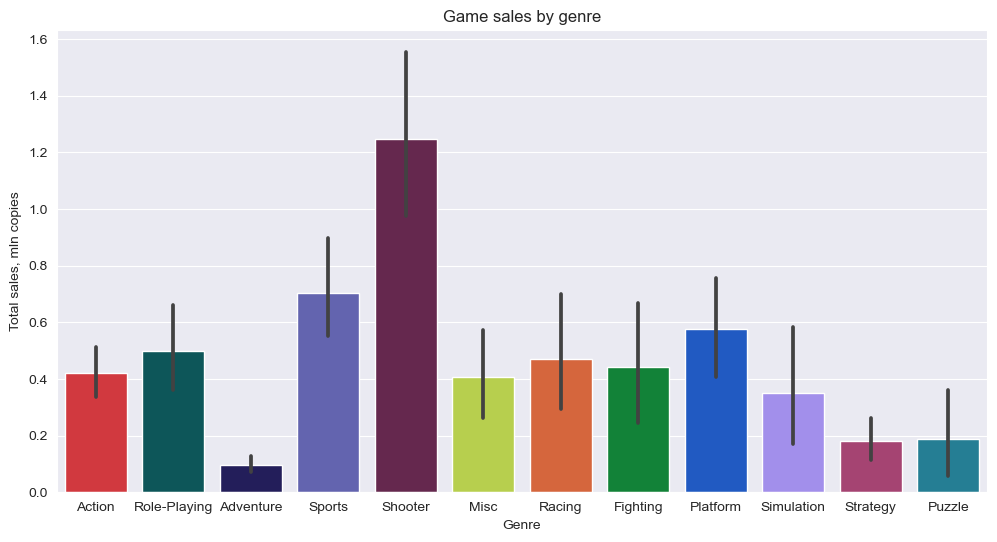

In [30]:
fig, ax = plt.subplots(figsize=(12, 6))
ax = sns.barplot(x='genre', 
                 y='total_sales', 
                 data=df_a, 
                 order=df_a['genre'].value_counts(ascending=False).index,
                palette=genre_palette)
plt.xlabel('Genre')
plt.ylabel('Total sales, mln copies')
plt.title('Game sales by genre');

Лучше всего продаются шутеры, дальше с большим отрывом идут платформеры и спортивные игры. Интересно получается, что самые продающиеся жанры отнюдь не самые массовые.

Самые низкие продажи у приключенческих игр, стратегий и паззлов.

## Портреты пользователей по регионам

### Топ-5 платформ по регионам
Покажем на графике какие платформы популярны в Северной Америке, Европе и Японии.

In [31]:
top_platforms = df_a.pivot_table(values=['na_sales','eu_sales','jp_sales'], index='platform', aggfunc='sum').reset_index()
top_platforms['eu_shares'] = top_platforms['eu_sales'] / top_platforms['eu_sales'].sum()
top_platforms['jp_shares'] = top_platforms['jp_sales'] / top_platforms['jp_sales'].sum()
top_platforms['na_shares'] = top_platforms['na_sales'] / top_platforms['na_sales'].sum()
top_platforms

,platform,eu_sales,jp_sales,na_sales,eu_shares,jp_shares,na_shares
0,3DS,30.96,67.81,38.20,0.078933,0.481674,0.087272
1,DS,0.85,0.00,0.57,0.002167,0.000000,0.001302
2,PC,25.36,0.00,11.11,0.064656,0.000000,0.025382
3,PS3,67.81,23.35,63.50,0.172883,0.165862,0.145073
4,PS4,141.09,15.96,108.74,0.359712,0.113368,0.248429
5,PSP,0.17,3.29,0.00,0.000433,0.023370,0.000000
6,PSV,6.10,18.59,5.04,0.015552,0.132050,0.011514
7,Wii,5.93,0.05,6.56,0.015119,0.000355,0.014987
8,WiiU,19.85,10.88,29.21,0.050608,0.077284,0.066734
9,X360,42.52,0.51,81.66,0.108406,0.003623,0.186562


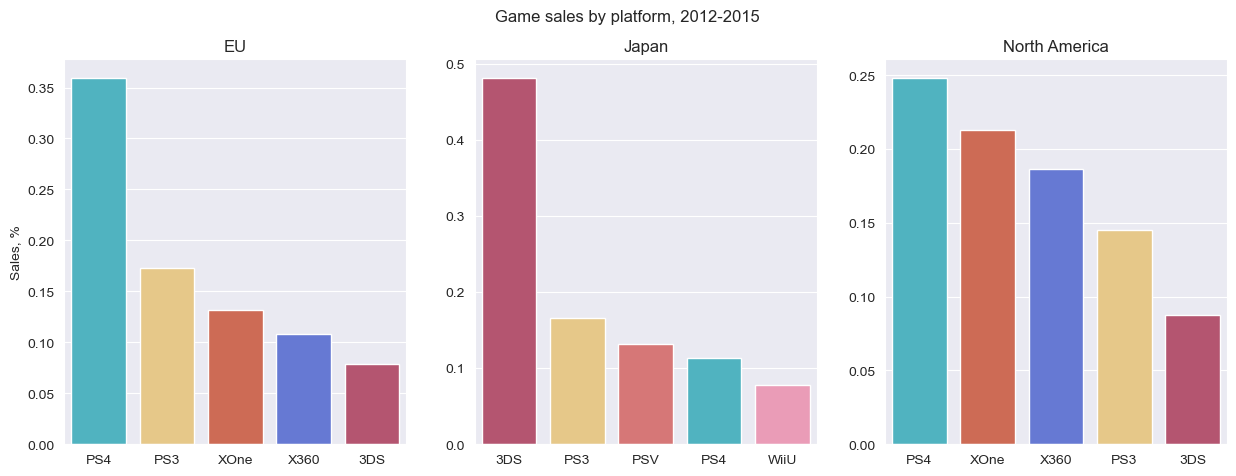

In [32]:
# Выберем топ-5 платформ для каждого региона
eu_platforms = top_platforms[['platform','eu_shares']].sort_values('eu_shares', ascending=False).head()
jp_platforms = top_platforms[['platform','jp_shares']].sort_values('jp_shares', ascending=False).head()
na_platforms = top_platforms[['platform','na_shares']].sort_values('na_shares', ascending=False).head()

# Покажем их на графике
fig, axes = plt.subplots(figsize=(15, 5), ncols=3)
sns.barplot(x='platform', 
            y='eu_shares', 
            data=eu_platforms, 
            order=eu_platforms.platform,
            palette = self_palette,
            ax=axes[0]) 
    
axes[0].set_title('EU')
axes[0].set_xlabel('')
axes[0].set_ylabel('Sales, %')

sns.barplot(x='platform', 
            y='jp_shares', 
            data=jp_platforms, 
            order=jp_platforms.platform,
            palette = self_palette,
            ax=axes[1]) 

axes[1].set_title('Japan')
axes[1].set_xlabel('')
axes[1].set_ylabel('')

sns.barplot(x='platform', 
            y='na_shares', 
            data=na_platforms, 
            order=na_platforms.platform,
            palette = self_palette,
            ax=axes[2]) 

axes[2].set_title('North America')
axes[2].set_xlabel('')
axes[2].set_ylabel('')

fig.suptitle('Game sales by platform, 2012-2015')
plt.show();

Структура продаж довольно сильно различается в Европе, Японии и Севреной Америке.

В **Северной Америке** на лидирующую платформу приходится всего 25% проданных игр, при этом у остальных платформ из топ-5 тоже весомые доли. Продажи между платформами от Microsoft и PlayStation распределяются довольно равномерно. Только платформы Nintendo в аутсайдерах.

В **Европе** явно отдают предпочтение PlayStation, Microsoft на втором месте, платформы Nintendo не особенно популярны.

В **Японии** сложился рынок одного игрока: 47% продаж приходится на игры для 3DS от Nintendo. PlayStation тоже на этом рынке присутствует, но игроки пока не перешли на платформу нового поколения.

### Топ-5 жанров по регионам
Покажем на графике какие жанры популярны в Северной Америке, Европе и Японии.

In [33]:
top_genres = df_a.pivot_table(values=['na_sales','eu_sales','jp_sales'], index='genre', aggfunc='sum').reset_index()
top_genres

,genre,eu_sales,jp_sales,na_sales
0,Action,118.13,40.49,126.05
1,Adventure,8.25,5.82,7.14
2,Fighting,8.55,7.65,15.55
3,Misc,20.04,9.20,27.49
4,Platform,15.58,4.79,18.14
5,Puzzle,1.00,1.18,0.83
6,Racing,20.19,2.30,12.96
7,Role-Playing,36.97,51.04,46.40
8,Shooter,87.86,6.61,109.74
9,Simulation,10.92,4.52,4.86


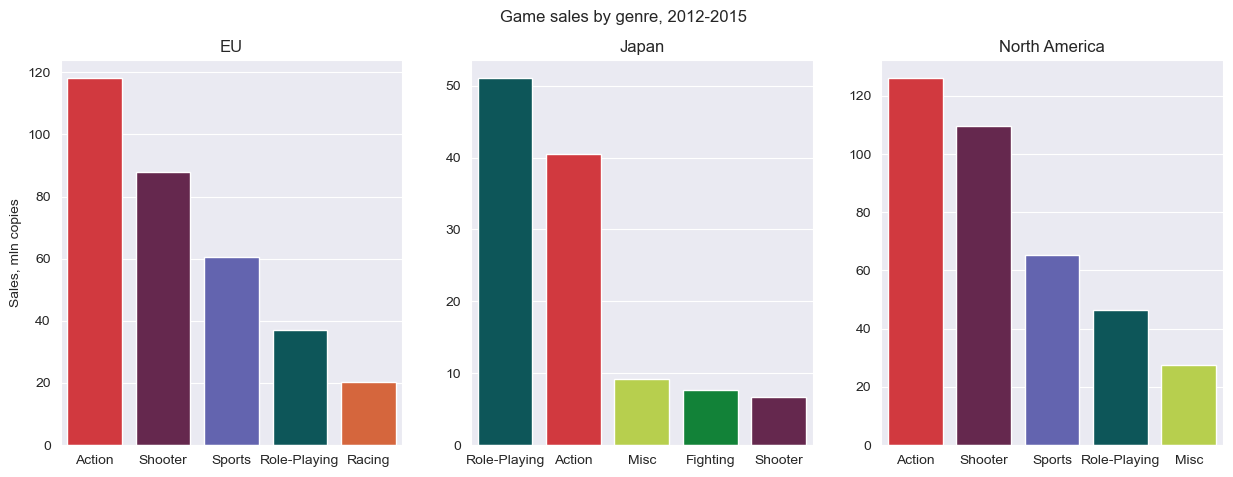

In [34]:
# Выберем топ-5 жанров для каждого региона
eu_genres = top_genres[['genre','eu_sales']].sort_values('eu_sales', ascending=False).head()
jp_genres = top_genres[['genre','jp_sales']].sort_values('jp_sales', ascending=False).head()
na_genres = top_genres[['genre','na_sales']].sort_values('na_sales', ascending=False).head()

# Покажем их на графике
fig, axes = plt.subplots(figsize=(15, 5), ncols=3)
sns.barplot(x='genre', 
            y='eu_sales', 
            data=eu_genres, 
            order=eu_genres.genre,
            palette = genre_palette,
            ax=axes[0]) 
    
axes[0].set_title('EU')
axes[0].set_xlabel('')
axes[0].set_ylabel('Sales, mln copies')

sns.barplot(x='genre', 
            y='jp_sales', 
            data=jp_genres, 
            order=jp_genres.genre,
            palette = genre_palette,
            ax=axes[1]) 

axes[1].set_title('Japan')
axes[1].set_xlabel('')
axes[1].set_ylabel('')

sns.barplot(x='genre', 
            y='na_sales', 
            data=na_genres, 
            order=na_genres.genre,
            palette = genre_palette,
            ax=axes[2]) 

axes[2].set_title('North America')
axes[2].set_xlabel('')
axes[2].set_ylabel('')

fig.suptitle('Game sales by genre, 2012-2015')
plt.show();

Популярные жанры в **Северной Америке** и **Европе** практически совпадают, а в **Японии** всё по-другому: в лидерах ролевые игры и экшн, а спортивные даже не вошли в топ-5.

### Влияние рейтинга ESRB на продажи
Возрастные органичения могут влиять на продажи там, где много игроков среди детей и подростков. Посмотрим, есть ли здесь различия по регионам.

In [35]:
# Зададим цвета для рейтингов, чтобы они одинаково отображались на всех графиках
rating_palette ={'M':'#45aaf2','E':'#fc5c65','E10+':'#26de81','T':'#a55eea','AO':'#fd9644',
                'EC':'#2bcbba','K-A':'#778ca3','RP':'#fed330'}

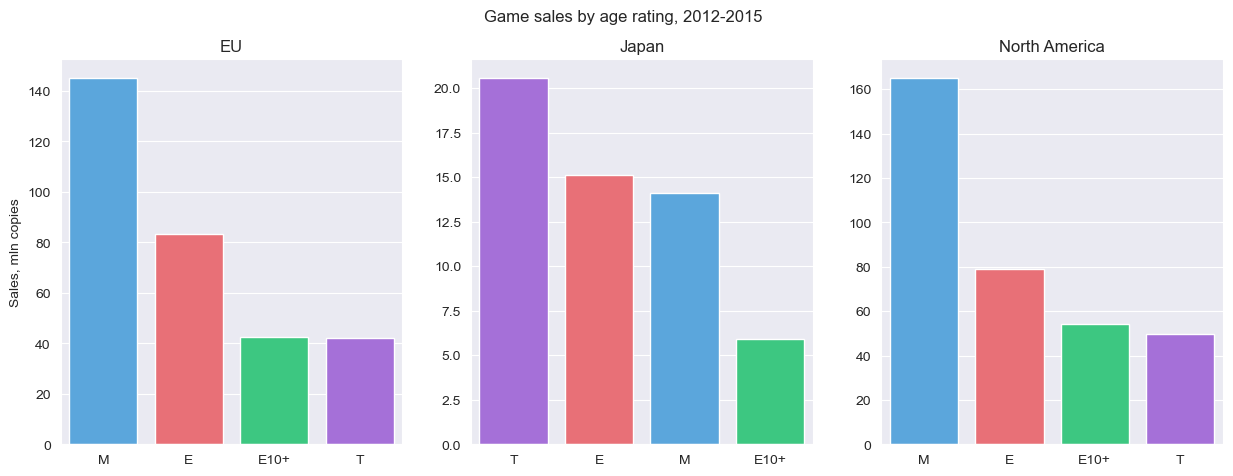

In [36]:
# Найдём продажи по рейтингам по убыванию для каждого региона
eu_rating = df_a.groupby('rating').sum(numeric_only=True)['eu_sales'].sort_values(ascending=False)
jp_rating = df_a.groupby('rating').sum(numeric_only=True)['jp_sales'].sort_values(ascending=False)
na_rating = df_a.groupby('rating').sum(numeric_only=True)['na_sales'].sort_values(ascending=False)

fig, axes = plt.subplots(figsize=(15, 5), ncols=3)
sns.barplot(x=eu_rating.index, 
            y=eu_rating, 
            order=eu_rating[eu_rating!=0].index,
            palette = rating_palette,
            ax=axes[0]) 
    
axes[0].set_title('EU')
axes[0].set_xlabel('')
axes[0].set_ylabel('Sales, mln copies')

sns.barplot(x=jp_rating.index, 
            y=jp_rating, 
            order=jp_rating[jp_rating!=0].index,
            palette = rating_palette,
            ax=axes[1]) 

axes[1].set_title('Japan')
axes[1].set_xlabel('')
axes[1].set_ylabel('')

sns.barplot(x=na_rating.index, 
            y=na_rating, 
            order=na_rating[na_rating!=0].index,
            palette = rating_palette,
            ax=axes[2]) 

axes[2].set_title('North America')
axes[2].set_xlabel('')
axes[2].set_ylabel('')

fig.suptitle('Game sales by age rating, 2012-2015')
plt.show();

В принципе, картина уже ясна, но для большей объективности покажем сколько вообще выходило игр с разным рейтингом в этом периоде.

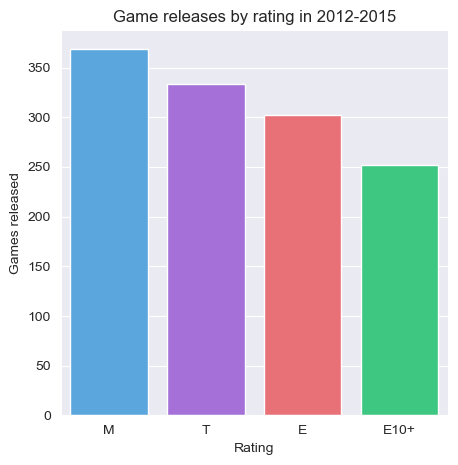

In [37]:
fig, ax = plt.subplots(figsize=(5, 5))
ax = sns.countplot(x=df_a['rating'], 
                   order=df_a['rating'].value_counts(ascending=False)[df_a['rating'].value_counts(ascending=False)>0].index, 
                   palette=rating_palette);

# abs_values = df_a['rating'].value_counts(ascending=False).values # Не работает в среде Практикума
# ax.bar_label(container=ax.containers[0], labels=abs_values)

plt.xlabel('Rating')
plt.ylabel('Games released')
plt.title('Game releases by rating in 2012-2015');

Игр с рейтингом М вышло больше, дальше в порядке убывания Т и Е. В любом случае, во всех анализируемых регионах распределение продаж по рейтингам отличается от распределения по количеству вышедших игр.

В **Европе** и в **Северной Америке** отдают предпочтение играм с рейтингом М (mature), а в **Японии** более популярны игры с рейтингом Е (everyone) и Т (teen).

**Вывод.** 

Если подытожить, вот какой портрет складывается для каждого региона:

***Европа:*** Самые популярные платформы PlayStation, Microsoft на втором месте, платформы Nintendo не особенно популярны. Самые продающиеся жанры - экшн, шутеры и спорт. Игроки отдают предпочтение играм с рейтингом М (mature).

***Северная Америка:*** Хотя лидирует платформа Х360 от Microsoft, в целом продажи между платформами от Microsoft и PlayStation распределяются довольно равномерно. Только платформы Nintendo в аутсайдерах. Самые продающиеся жанры - экшн, шутеры и спорт. Игроки отдают предпочтение играм с рейтингом М (mature).

***Япония:*** 45% продаж приходится на игры для 3DS от Nintendo. PlayStation тоже на этом рынке присутствует, но игроки пока не перешли на платформу нового поколения. Самые популярные жанры - ролевые игры и экшн. Более популярны игры с рейтингом Е (everyone) и Т (teen).

## Проверка гипотез
### Гипотеза 1: Средние пользовательские рейтинги платформ Xbox One и PC одинаковые
Посчитаем средние пользовательские рейтинги для Xbox One и PC:

In [38]:
df_a.loc[df_a['platform']=='XOne','user_score'].dropna().mean()

6.521428571428572

In [39]:
df_a.loc[df_a['platform']=='PC','user_score'].dropna().mean()

6.2696774193548395

Значения довольно близкие, но сложно сказать насколько значима разница в несколько десятых балла.

Сформулируем нулевую и альтернативную гипотезы и зададим пороговое значение *alpha*:
```
H_0: Средние пользовательские рейтинги (user_score) игр для платформы Xbox One (XOne) = средние пользовательские 
рейтинги (user_score) игр для платформы PC`
H_a: Средние пользовательские рейтинги (user_score) игр для платформы Xbox One (XOne) ≠ средние пользовательские 
рейтинги (user_score) игр для платформы PC`
alpha = 0.05
```

*Нулевая гипотеза* выражает предположение, что различия между средними значениями двух совокупностей имеют случайный характер. *Альтернативная гипотеза* предполагает, что между средними значениями двух совокупностей есть достоверные различия.

Для проверки правдоподобия гипотез используем t-критерий Стьюдента, а именно двухвыборочный t-критерий для независимых выборок, так как оценки пользователей для игр на одной платформе не связаны с оценками игр на другой платформе.

In [40]:
# results = вызов метода для проверки гипотезы
results = st.ttest_ind(df_a.loc[df_a['platform']=='XOne','user_score'].dropna(), 
                       df_a.loc[df_a['platform']=='PC','user_score'].dropna(),
                      equal_var=False)

# alpha = зададим значение уровня значимости
alpha = .05

# вывод значения p-value на экран 
print('p-value:', results.pvalue)
# условный оператор с выводом строки с ответом
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
# если p-value окажется меньше него, отвергнем гипотезу
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-value: 0.14759594013430463
Не получилось отвергнуть нулевую гипотезу


Нулевая гипотеза не отвергается, значит нельзя сделать вывод, что средние пользовательские рейтинги игр для Xbox One и PC отличаются.

### Гипотеза 2: Средние пользовательские рейтинги жанров Action и Sports разные
Посчитаем средние пользовательские рейтинги для жанров Action и Sports:

In [41]:
df_a.loc[df_a['genre']=='Action','user_score'].dropna().mean()

6.837532133676092

In [42]:
df_a.loc[df_a['genre']=='Sports','user_score'].dropna().mean()

5.238124999999999

Различие заметное. Снова применим t-тест, чтобы понять насколько оно значимо.

Сформулируем нулевую и альтернативную гипотезы и зададим пороговое значение *alpha*:
```
H_0: Средние пользовательские рейтинги (user_score) игр в жанре Action = средние пользовательские рейтинги (user_score) 
игр в жанре Sports`
H_a: Средние пользовательские рейтинги (user_score) игр в жанре Action ≠ средние пользовательские рейтинги (user_score) 
игр в жанре Sports`
alpha = 0.05
```

In [43]:
# results = вызов метода для проверки гипотезы
results = st.ttest_ind(df_a.loc[df_a['genre']=='Action','user_score'].dropna(), 
                       df_a.loc[df_a['genre']=='Sports','user_score'].dropna(),
                      equal_var=False) # выборки разного размера, поэтому считаем, что дисперсия не равная.

# alpha = зададим значение уровня значимости
alpha = .05

# вывод значения p-value на экран 
print('p-value:', results.pvalue)
# условный оператор с выводом строки с ответом
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
# если p-value окажется меньше него, отвергнем гипотезу
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-value: 1.4460039700704315e-20
Отвергаем нулевую гипотезу


Нулевая гипотеза отвергается, значит можно сказать, что пользовательские рейтинги жанров Action и Sports разные.

## Общий вывод

Больше всего игр в год выходило с 2005 по 2011 годы. С 2012 года на рынок начало выходить новое поколение консолей, а значит имеет смысл считать это актуальным периодом для анализа.

**Состояние рынка видеоигр**

У каждого из ключевых производителей консолей на рынке к 2015 году присутствует несколько моделей. Новые модели PlayStation и Nintendo обогнали по продажам старые, а вот XOne от Microsoft отстаёт от X360. Заметно падают в продажах PS3 и X360, их место в топе занимают PS4 и XOne. Также уходят со сцены 3DS, Wii и PSP. WiiU, скорее всего, исчерпала свой потенциал роста и тоже будет снижаться.

Можно предположить, что в 2016 году лидерами продаж будут **PS4** и **XOne**, на них и следует делать главную ставку в продвижении.

Почти на каждой платформе есть "выстрелившие" игры, которые продаются миллионами копий. Однако если их отбросить, то в среднем больше популярных игр вышло на платформе X360 (медианные продажи для игры на X360 - 0,31 млн. копий). Ко "второму эшелону" по средним продажам игр можно отнести PS3, PS4, XOne, Wii и WiiU.

**Как отзывы влияют на продажи**

Оценки критиков положительно коррелируют с продажами для всех платформ, кроме PSV. Оценки пользователей положительно коррелируют с продажами только для платформ Nintendo (2DS, WiiU). Оценки пользователей для игр на PC имеют слабую обратную корреляцию с продажами.

**Популярные и непопулярные жанры**

Больше всего выпускается игр в жанре action, также много ролевых, приключенческих, спортивных и шутеров. Лучше всего продаются шутеры, дальше с большим отрывом идут платформеры и спортивные игры. Получается, что самые продающиеся жанры отнюдь не самые массовые. Самые низкие продажи у приключенческих игр, стратегий и паззлов.

**Портреты пользователей из Европы, Северной Америки и Японии**

Вот какой портрет складывается для каждого региона:

***Европа:*** Самые популярные платформы PlayStation, Microsoft на втором месте, платформы Nintendo не особенно популярны. Самые продающиеся жанры - экшн, шутеры и спорт. Игроки отдают предпочтение играм с рейтингом М (mature).

***Северная Америка:*** Хотя лидирует платформа Х360 от Microsoft, в целом продажи между платформами от Microsoft и PlayStation распределяются довольно равномерно. Только платформы Nintendo в аутсайдерах. Самые продающиеся жанры - экшн, шутеры и спорт. Игроки отдают предпочтение играм с рейтингом М (mature).

***Япония:*** 45% продаж приходится на игры для 3DS от Nintendo. PlayStation тоже на этом рынке присутствует, но игроки пока не перешли на платформу нового поколения. Самые популярные жанры - ролевые игры и экшн. Более популярны игры с рейтингом Е (everyone) и Т (teen).

**Результат статистической проверки гипотез:**

Нельзя сказать, что средние пользовательские рейтинги игр для Xbox One и PC отличаются.
Можно сказать, что пользовательские рейтинги жанров Action и Sports разные.

### Рекомендации для продвижения в 2017 году
Рекомендуем обратить внимание на растущие в популярности платформы **PlayStation 4** и **Microsoft XOne**.
Драйвером продаж часто становятся **шутеры**. Также следует обращать внимание на **спортивные игры и платформеры** - их выходит не так много, но они имеют свою заметную аудиторию и вложения в их продвижение с большей вероятностью окупятся.

В качестве инструментов продвижения рекомендуем обратить внимание на **отзывы критиков**. Можно публиковать выдержки из отзывов в карточке товара, можно размещать рекламу магазина у известных критиков. И конечно нужно отслеживать отзывы критиков, чтобы, например, своевременно приостановить продвижение игр, получающих много негативных оценок.

Для каждого региона нужно делать отдельную программу, потому что предпочтения игроков в Европе, Северной Америке и Японии в некоторых аспектах существенно отличаются.